In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing librares

In [2]:
import sys
sys.path.append("../src/")

In [3]:
import pandas as pd
import random as rn
import multiprocessing
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [ ]:
#!pip install -U gensim

In [ ]:
#!pip install nltk

In [ ]:
#!pip install wordcloud

In [5]:
import collections
from tqdm import tqdm
from gensim.models import word2vec

from textDataset import *
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import calinski_harabaz_score,silhouette_score
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud,STOPWORDS
from scipy.stats import norm

In [6]:
cpu_count = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 15


# Text preprocessing

In [ ]:
#import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')

In [7]:
path2data = '../../'
#path2data = '../data/news_headlines/'

text = {
        'train': TextDataset(path2data, extension='.csv', sep=',', is_train = True),
}    

In [8]:
col = 'headline_text'
text['train'].process_data(col = col, remove_stopw = True, remove_tags=False, lemmalize = True, stem = True)

In [9]:
print('Dataset lenght: {}'.format(len(text['train'].data)))

Dataset lenght: 643715


In [10]:
text['train'].data.publish_date = pd.to_datetime(text['train'].data.publish_date.astype(str),format='%Y-%m-%d')

In [11]:
text['train'].data.head()

,publish_date,headline_text,subject,headline_text_data,nb_words
0,2003-03-03,unhooked brakes to blame for taiwan train disa...,news_headlines,"[unhook, brake, blame, taiwan, train, disast]",6
1,2003-09-18,oldest prisoner in tas released citing health,news_headlines,"[oldest, prison, ta, releas, cite, health]",6
5,2003-06-01,tougher water restrictions loom after dry may,news_headlines,"[tougher, water, restrict, loom, dri, may]",6
7,2003-07-23,minardi sign italian bruni as test driver,news_headlines,"[minardi, sign, italian, bruni, test, driver]",6
8,2003-09-10,man breaks leg in cliff fall,news_headlines,"[man, break, leg, cliff, fall]",5


In [12]:
text['train'].data.publish_date.describe()

count                  643715
unique                   5422
top       2012-08-14 00:00:00
freq                      238
first     2003-02-19 00:00:00
last      2017-12-31 00:00:00
Name: publish_date, dtype: object

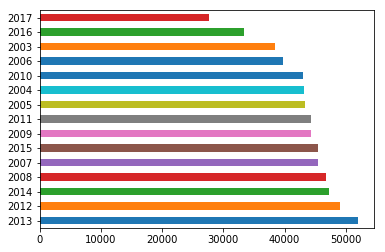

In [13]:
text['train'].data.publish_date.dt.year.value_counts().plot(kind = 'barh')

# Extracting Features

In [14]:
features_extractor = 'word2Vec'
#features_extractor = 'bow'

In [15]:
def buildWordVector(model, tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model[word].reshape((1, size))
            count += 1.
        except KeyError: 
            continue
    return vec

In [16]:
# Reference: https://www.kaggle.com/c/word2vec-nlp-tutorial#part-3-more-fun-with-word-vectors

def makeFeatureVec(words, model, num_features):
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec, model[word])
    # Divide the result by the number of words to get the average
    if nwords == 0:
        nwords = 1
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [17]:
# Reference: https://www.kaggle.com/c/word2vec-nlp-tutorial#part-3-more-fun-with-word-vectors

def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews), num_features), dtype="float32")
    counter = 0
    # Loop through the reviews
    for review in reviews:
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [138]:
def extract_features(X_train, features_extractor = 'word2Vec', max_gram = 2, concat_method= 'average', scale_vectors = True):

    print('Features extractor: {}'.format(features_extractor))

    if features_extractor == 'bow':

        print('Counting ocorrences of words. Ngram-range: {}...'.format(str((1,max_gram))))
        vectorizer = CountVectorizer(analyzer = "word",
                                     max_features = 300, ngram_range=(1,max_gram)) 
        f_train = vectorizer.fit_transform([" ".join(x) for x in X_train])

        #downscale weights for words using tf–idf: “Term Frequency times Inverse Document Frequency”.
        print('Words downscaling using TF-IDF...')

        tfidf_transformer = TfidfTransformer()
        f_train = tfidf_transformer.fit_transform(f_train)
        
        model = vectorizer

    else:

        # Set values for various parameters
        num_features = 450    # Word vector dimensionality                      
        min_word_count = 80   # Minimum word count                        
        num_workers = cpu_count  # Number of threads to run in parallel
        context = 4             # Context window size                                                                                    
        downsampling = 1e-5   # Downsample setting for frequent words (default value)


        print('Creating Word2Vec Model...')
        model = word2vec.Word2Vec(workers=num_workers, \
                    size=num_features, min_count = min_word_count, \
                    window = context, sample = downsampling)


        model.build_vocab(X_train)
        model.train(X_train, \
                    total_examples=model.corpus_count, epochs=model.epochs)
        
        
        if concat_method == 'average':
            f_train = getAvgFeatureVecs(X_train, model, num_features)
        elif concat_method == 'sum':
            f_train = np.concatenate([buildWordVector(model, z, num_features) for z in map(lambda x: x, X_train)])
        else:
            avg_  = getAvgFeatureVecs( X_train, model, num_features )
            sum_  = np.concatenate([buildWordVector(model, z, num_features) for z in map(lambda x: x, X_train)])
            f_train = np.concatenate([sum_,avg_],axis=1)
        
        if scale_vectors:
            print("Scaling feature matrix")
            scaler = StandardScaler()
            f_train = scaler.fit_transform(f_train)
                
    return f_train, model

### Find number of clusters

In [142]:
def find_nb_clusters(f_train, kmax = 25, plot=True,figsize=(12,4), path2save = ''):
    wcss = []
    cali = []
    
    print('Max number of clusters for MiniBatchKMeans: {}'.format(kmax))
    for i in tqdm(range(2, kmax)):
        kmeans = MiniBatchKMeans(n_clusters = i, init = 'k-means++',
                                 n_init=1,init_size= int(1e3),
                                 random_state = 42,batch_size=int(1e3))
        kmeans.fit(f_train)
        wcss.append(kmeans.inertia_)
        ypred = kmeans.predict(f_train)
        cali.append(calinski_harabaz_score(f_train,ypred))
        
    if plot:

        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        plt.plot(range(2, kmax), cali, '-o')
        plt.title('Calinski Harabaz Score')
        plt.xlabel('Number of clusters')
        plt.ylabel('Score')
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(range(2, kmax), wcss, '-o')
        plt.title('The Elbow Method (WCSS)')
        plt.xlabel('Number of clusters')
        plt.ylabel('Score')
        plt.grid()
        plt.show()
        
        
        fig.savefig(path2save)
        
    return wcss, cali

# Quantitative Cluster Analysis

In [20]:
def calculate_cluster_variance(f_train, n_clusters=4):

    kmeans = MiniBatchKMeans(n_clusters = n_clusters, init = 'k-means++',
                                 n_init=1,init_size= int(1e3),
                                 random_state = 42,batch_size=int(1e3))
    kmeans.fit(f_train)
        
    ypred = kmeans.predict(f_train)

    #np.unique(ypred,return_counts=True)
    tmp =np.concatenate([f_train,ypred.reshape(-1,1)],axis=1)
    var=[]
    for cluster in range(n_clusters): 
        var.append(np.var(tmp[tmp[:,-1]==cluster]))

    return var

# Qualitative Cluster Analysis

In [21]:
def get_corpus(data):
    corpus = []
    for i in data:
        for j in i:
            corpus.append(j)
    return corpus    

In [22]:
def get_wordCloud(corpus):
    
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str(corpus))
    return wordCloud

In [23]:
def count_most_frequent_words(corpus, n_print = 5):

    word_counter = collections.Counter(procTextCorpus)
    for word, count in word_counter.most_common(n_print):
        print(word, ": ", count)
    return word_counter

In [24]:
directory_lst = ['./figs/elbow/', './figs/qualitative_analysis/',
                 './figs/quantitative_analysis/']
for directory in directory_lst:    
    if not os.path.exists(directory):
        os.makedirs(directory)

## Cluster analysis for each year

In [80]:
text['train'].data.publish_date.dt.year.unique()

15

Dataset length: 44387. Year: 2011
Features extractor: word2Vec
Creating Word2Vec Model...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:06<00:00,  2.75it/s]


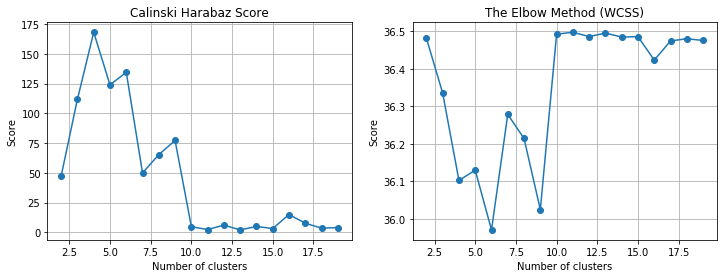

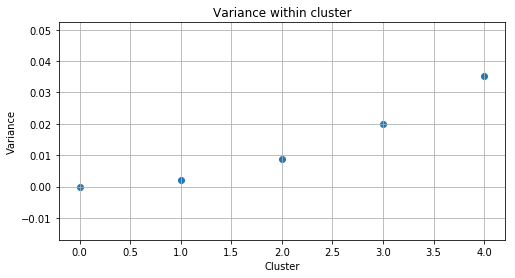

polic :  1242
man :  1195
flood :  1156
new :  1059
call :  809


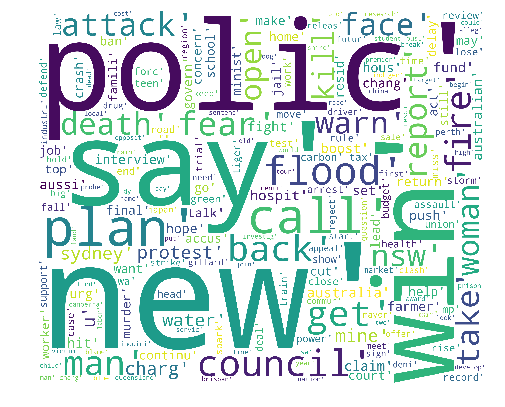

Dataset length: 45448. Year: 2007
Features extractor: word2Vec
Creating Word2Vec Model...


  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


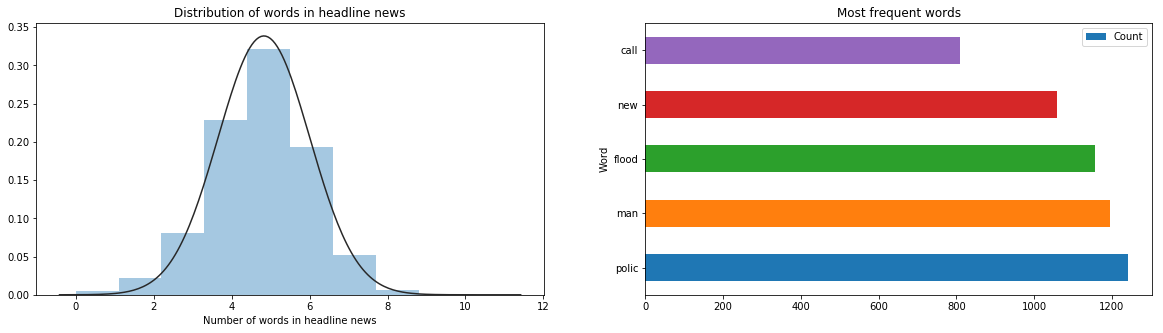

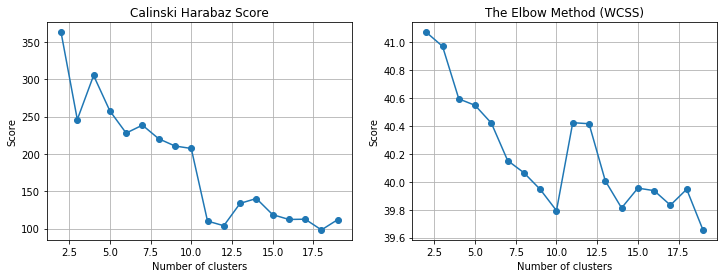

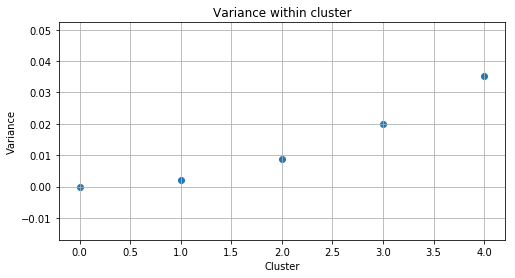

polic :  1990
govt :  1699
man :  1241
new :  1191
say :  1187


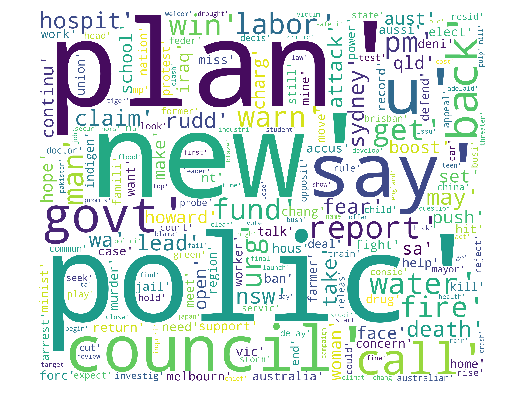

Dataset length: 38396. Year: 2003
Features extractor: word2Vec
Creating Word2Vec Model...


  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:08<00:00,  2.13it/s]


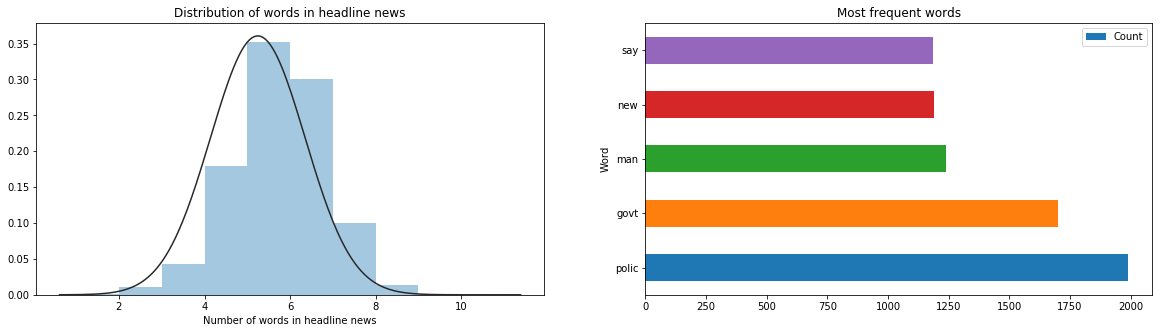

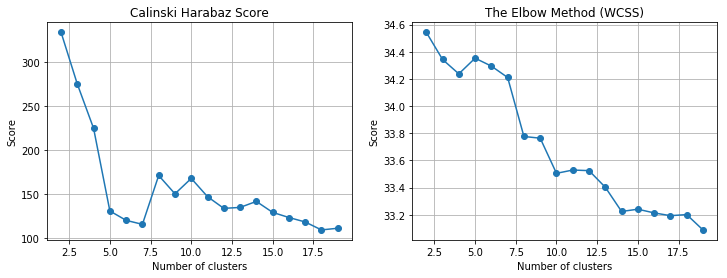

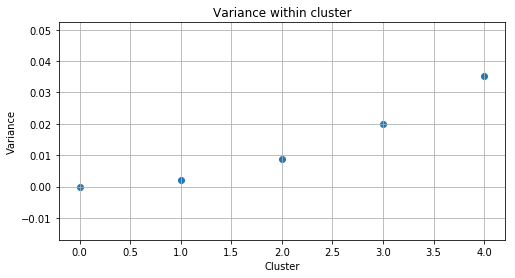

u :  1485
polic :  1343
govt :  1221
plan :  1160
new :  1082


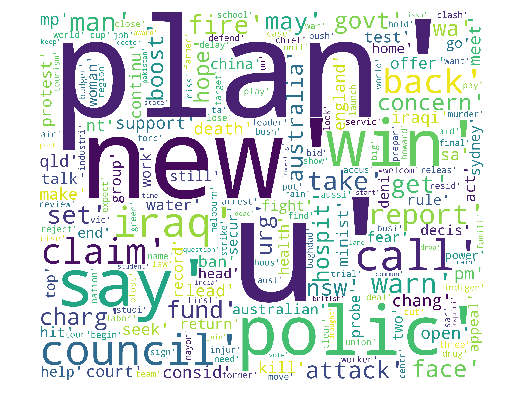

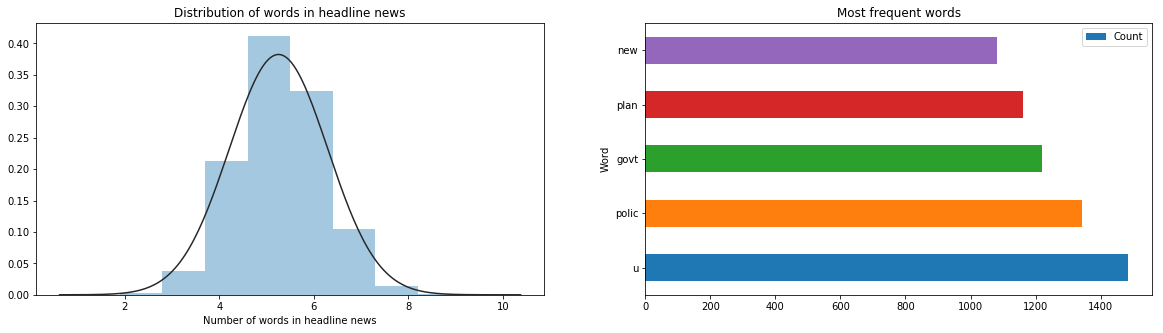

In [83]:
min_year = text['train'].data.publish_date.dt.year.min()
max_year = text['train'].data.publish_date.dt.year.max()
#years = text['train'].data.publish_date.dt.year.unique().tolist()
#years = rn.sample(years,3)

for y in np.arange(min_year, max_year):
#for y in years:

    X_train = text['train'].data[text['train'].data.publish_date.dt.year == y]
    
    print('Dataset length: {}. Year: {}'.format(len(X_train), y))
    f_train, _ = extract_features(X_train[col + '_data'].values, concat_method='sum',scale_vectors=False)
    
    path2save = './figs/elbow/' + features_extractor + 'ElbowRule'+'_'+str(y)+'.png'
    
    find_nb_clusters(f_train, kmax=20, path2save = path2save)
    
        
    n_clusters= 5
    
    ## Quantitative Analysis
    var = calculate_cluster_variance(f_train, n_clusters = n_clusters)
    
    fig = plt.figure(figsize=(8,4))
    plt.scatter(range(0, n_clusters), var)
    plt.title('Variance within cluster')
    plt.xlabel('Cluster')
    plt.ticklabel_format(style='plain',axis='x',useOffset=False)
    plt.ylabel('Variance')
    plt.grid()
    plt.show()
    fig.savefig('./figs/quantitative_analysis/'+ features_extractor +'Variance_' + str(n_clusters) +'C.png')

    ## Qualitative Analysis
    procTextCorpus = get_corpus(X_train[col + '_data'])
    procWordCloud = get_wordCloud(procTextCorpus)
    n_print = 5
    word_counter = count_most_frequent_words(procTextCorpus, n_print = n_print)
                          
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(procWordCloud)
    plt.axis('off')
    plt.show()
    fig.savefig('./figs/qualitative_analysis/'+ features_extractor + 'word_clouds.png')
    
    
    fig = plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)

    sns.distplot(X_train['nb_words'],hist=True, kde=False, bins=10, fit=norm)
    plt.title("Distribution of words in headline news")
    plt.xlabel('Number of words in headline news')

    ax = fig.add_subplot(1,2,2)
    lst = word_counter.most_common(n_print)
    df = pd.DataFrame(lst, columns = ['Word', 'Count'])
    plt.title('Most frequent words')
    df.plot(kind="barh",x='Word',y='Count', ax=ax)

    fig.savefig('./figs/qualitative_analysis/'+ features_extractor + 'word_counter.png')

## Cluster analysis for whole dataset

In [120]:
X_train = text['train'].data[col + '_data']

In [121]:
X_train[0]

['unhook', 'brake', 'blame', 'taiwan', 'train', 'disast']

In [139]:
f_train, W2Vmodel = extract_features(X_train, concat_method='average',scale_vectors=False)

Features extractor: word2Vec
Creating Word2Vec Model...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [130]:
print('Shape of train features: {}'.format(f_train.shape))

Shape of train features: (643715, 450)


In [136]:
X_train.shape, f_train.shape

((643715,), (643715, 450))

### Find number of clusters

  0%|          | 0/23 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 25


100%|██████████| 23/23 [01:35<00:00,  4.14s/it]


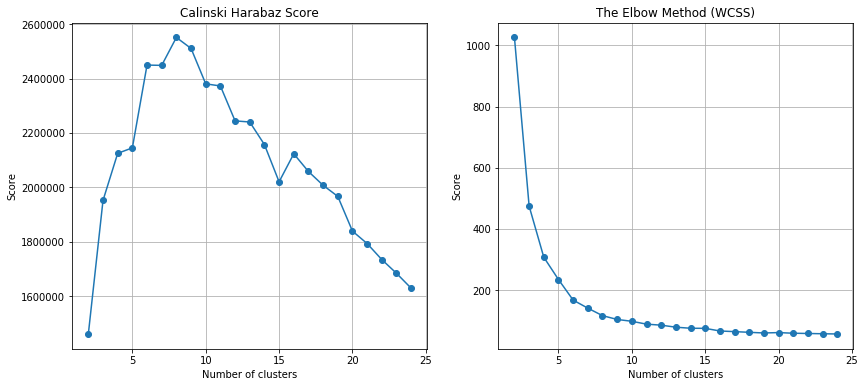

In [145]:
path2save = './figs/elbow/'+ features_extractor +'ElbowRule.png'
wcss,cali = find_nb_clusters(f_train, kmax=25, path2save=path2save,figsize=(14,6))

# Clusters analysis

In [146]:
del X_train

In [147]:
n_clusters = 8 # From the Number of Clusters Analysis

In [148]:
kmeans = MiniBatchKMeans(n_clusters = n_clusters, init = 'k-means++',
                         n_init=1,init_size= int(1e3),
                         random_state = 42,batch_size=int(1e3))
kmeans.fit(f_train)
ypred = kmeans.predict(f_train)

# Headlines analysis for each clusters

In [151]:
text['train'].data['Clusters'] = ypred 
text['train'].data.head(3)

,publish_date,headline_text,subject,headline_text_data,nb_words,Clusters
0,2003-03-03,unhooked brakes to blame for taiwan train disa...,news_headlines,"[unhook, brake, blame, taiwan, train, disast]",6,0
1,2003-09-18,oldest prisoner in tas released citing health,news_headlines,"[oldest, prison, ta, releas, cite, health]",6,5
5,2003-06-01,tougher water restrictions loom after dry may,news_headlines,"[tougher, water, restrict, loom, dri, may]",6,6


## Count headlines analysis

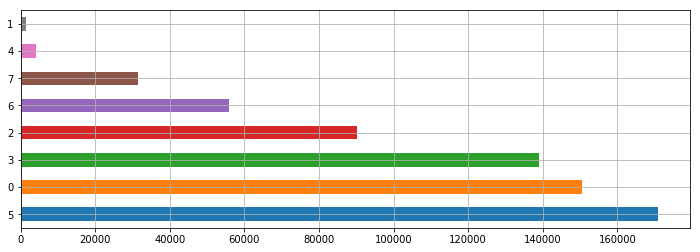

In [164]:
text['train'].data.Clusters.value_counts().plot(kind = 'barh',grid=True, figsize=(12,4))

## Theme Analysis

In [161]:
n_s = 10

for cluster in range(0,n_clusters):
    
    print (f"\n Showing headlines of cluster {cluster}:")
    
    samples = text['train'].data[text['train'].data.Clusters == cluster]['headline_text'].sample(10)

    print(f'\n{samples}')
    print('-'*80)


 Showing headlines of cluster 0:

686443                     chemical tank explodes at mt isa
619364                  passenger plane crashes in pakistan
217786            abbott seeks to boost organ donation rate
445579     teachers lobby for better conditions at brisbane
48804         major parties criticised for simplistic crime
254444       drought creates strong interest in snowy hydro
639768    housing plan for intellectually impaired defen...
787806    men sentenced over importation of drugs in cer...
563916       hotter drier climate to affect pine plantation
201131          act caravan park residents protest at civic
Name: headline_text, dtype: object
--------------------------------------------------------------------------------

 Showing headlines of cluster 1:

623876                                peacockdust
728102                            hawker thatcher
729566                        an maldives nasheed
594163          7rar edinburgh horseshoe barracks
683883        

## Statiscal  analysis 

In [165]:
text['train'].data.columns

Index(['publish_date', 'headline_text', 'subject', 'headline_text_data',
       'nb_words', 'Clusters'],
      dtype='object')

In [171]:
df_stats= pd.concat([text['train'].data.groupby(by='Clusters')['publish_date'].apply(lambda x: x.dt.year.nunique()),
                     text['train'].data.groupby(by='Clusters')['headline_text'].count(),
                     text['train'].data.groupby(by='Clusters')['nb_words'].mean()],axis=1)
df_stats.columns = ["Unique Years","Number of Headlines","Average of words in headlines"]

In [172]:
df_stats

,Unique Years,Number of Headlines,Average of words in headlines
Clusters,,,
0,15,150593,5.416925
1,15,1502,2.003995
2,15,90102,5.291570
3,15,138980,5.480026
4,15,4079,3.763422
5,15,170991,5.533794
6,15,55968,5.008451
7,15,31500,4.912762


# Words analysis in each clusters

In [32]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( W2Vmodel.wv.index2word, ypred ))

# For the first 5 clusters
for cluster in range(0,n_clusters):
    
    print (f"\n Cluster {cluster}:")
    words = []
    for key, value in word_centroid_map.items():
        if( value == cluster ):
            words.append(key)
    
    print(f'{rn.sample(words,10)}')


 Cluster 0:
['ham', '200m', 'coup', 'judgement', 'bennett', 'watchdog', 'haneef', 'walsh', 'kosciuszko', 'salt']

 Cluster 1:
['marijuana', 'dalbi', 'brush', 'refund', 'hoffman', 'kyrgio', 'lee', 'wesfarm', 'boost', 'scammer']

 Cluster 2:
['senior', 'pa', 'landcar', 'mla', 'oil', 'patient', 'muster', 'oscar', 'norman', 'smile']

 Cluster 3:
['indec', 'wilkinson', 'cobb', 'shanghai', 'bbl', 'oat', 'surcharg', 'fairytal', 'disagre', 'iraq']

 Cluster 4:
['pine', 'complex', 'alzheim', 'hu', 'attorney', 'daili', 'settlement', 'journey', 'tara', 'van']

 Cluster 5:
['morsi', 'act', 'scg', 'uni', 'brimbl', 'rehab', 'fee', 'lloyd', 'foley', 'approach']

 Cluster 6:
['vacanc', 'fox', 'hide', 'lesson', 'right', 'cabl', 'hen', 'carnarvon', 'castro', 'input']


### Number of words in each cluster

In [ ]:
words_map_series = pd.Series(word_centroid_map, index=word_centroid_map.keys())

In [ ]:
fig  = plt.figure(figsize=(15,5))
plt.title('Number of words in each cluster', fontsize = 16)
words_map_series.value_counts().plot(kind = 'barh')
plt.xlabel('Words count', fontsize = 16)
plt.ylabel('Clusters', fontsize = 16)
fig.savefig('./figs/quantitative_analysis/' + 'words_count_each_cluster_' + str(n_clusters) + 'C.png')

In [ ]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA


def plot_pca(f_train, y_train, nb_clusters = 4):

    palette = np.array(sns.color_palette("hls", nb_clusters))

    pca = PCA(n_components=3)
    result = pca.fit_transform(f_train)
    

    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(result[:, 0], result[:, 1],result[:, 2],
               s=40, c=palette[ypred.astype(np.int)])

    plt.title('Visualization PCA')
    plt.grid()
    plt.show()

In [ ]:
plot_pca(f_train, ypred)

## Words visualization using t-SNE

In [ ]:
import bokeh.plotting as bp
from sklearn.manifold import TSNE
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook



def plot_tSNE(model,n_samples = 5000):

    
    #https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm

    output_notebook()
    fig = bp.figure(plot_width=700, plot_height=600, title="A map of " + str(n_samples) + " word vectors",
        tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
        x_axis_type=None, y_axis_type=None, min_border=1)


    word_vectors = [model[w] for w in model.wv.vocab.keys()][:n_samples]
    #word_vectors = [token for token in f_matrix_train][0:n_samples]
    word_centroid_map = dict(zip( model.wv.index2word, ypred ))



    tsne_model = TSNE(n_components=2, verbose=1, random_state=23)
    tsne_w2v = tsne_model.fit_transform(word_vectors)

    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['words'] = [k for k in model.wv.vocab.keys()][:n_samples]

    fig.scatter(x='x', y='y', source=tsne_df)
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips={"word": "@words"}
    show(fig)

In [ ]:
plot_tSNE(W2Vmodel)

# Quantitative Cluster Analysis

In [ ]:
var = calculate_cluster_variance(f_train,n_clusters)

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(range(0, n_clusters), var)
plt.title('Variance within cluster')
plt.xlabel('Cluster')
plt.ticklabel_format(style='plain',axis='x',useOffset=False)
plt.ylabel('Variance')
plt.grid()
plt.show()
#plt.savefig('./Variance_4C.png')

In [ ]:
procTextCorpus = get_corpus(text['train'].data['headline_text_data'])

### Word Cloud Visualization

In [ ]:
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [ ]:
procWordCloud = get_wordCloud(procTextCorpus)

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(procWordCloud)
plt.axis('off')
plt.show()
fig.savefig('./figs/all_data_word_clouds.png')

### Most frequent words

In [ ]:
word_counter = count_most_frequent_words(procTextCorpus)

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,2,1)

sns.distplot(text['train'].data['nb_words'],hist=True, kde=False, bins=10, fit=norm)
plt.title("Distribution of words in headline news")
plt.xlabel('Number of words in headline news')

ax = fig.add_subplot(1,2,2)
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
plt.title('Most frequent words')
df.plot(kind="barh",x='Word',y='Count', ax=ax)
fig.savefig('./figs/qualtitative_analysis/' + 'words_counter.png')